In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10  # Using CIFAR-10 as a sample dataset


In [2]:
# Load CIFAR-10 dataset and normalize
(x_train, _), (x_test, _) = cifar10.load_data()
x_train, x_test = x_train.astype("float32") / 255.0, x_test.astype("float32") / 255.0

# Keep only the R and G channels
x_train_rg = x_train[..., :2]  # Shape will be (batch_size, 32, 32, 2)
x_test_rg = x_test[..., :2]

In [4]:
input_img = Input(shape=(32, 32, 2))

# Encoder
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2D(16, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(2, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

In [5]:
autoencoder.fit(
    x_train_rg,
    x_train_rg,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_rg, x_test_rg),
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0227 - val_loss: 0.0071
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.0040 - val_loss: 0.0041


### Evaluate/Visualize

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041
Mean Squared Error (MSE) on 2-channel (RG) data: 0.0041


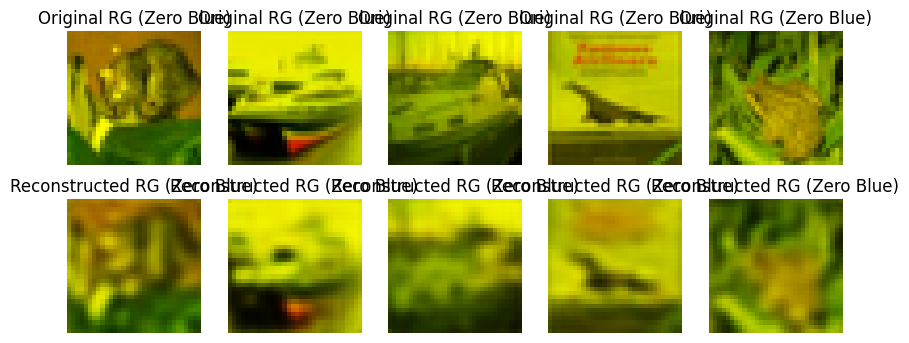

In [7]:
# Evaluate the model performance on the R and G channels
mse_rg = autoencoder.evaluate(x_test_rg, x_test_rg, batch_size=128)
print(f"Mean Squared Error (MSE) on 2-channel (RG) data: {mse_rg:.4f}")

import numpy as np
import matplotlib.pyplot as plt

# Create a zero blue channel and add it to the RG test images
n = 5  # Number of images to display
blue_channel = np.zeros(
    (x_test_rg.shape[0], 32, 32, 1)
)  # Shape: (batch_size, 32, 32, 1)
x_test_rg_rgb = np.concatenate([x_test_rg, blue_channel], axis=-1)
decoded_imgs_rg_rgb = np.concatenate([decoded_imgs_rg, blue_channel], axis=-1)

# Display original and reconstructed images with a zero blue channel
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original RG (mock RGB with zero blue channel)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_rg_rgb[i])
    plt.title("Original RG (Zero Blue)")
    plt.axis("off")

    # Display reconstructed RG (mock RGB with zero blue channel)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_rg_rgb[i])
    plt.title("Reconstructed RG (Zero Blue)")
    plt.axis("off")
plt.show()

## Step 2: Expand the Network for a New Dimension (Add B Channel)
To add a new feature dimension throughout the existing model, we will expand each layer to accommodate 3 channels (R, G, and B) instead of 2. We'll initialize the weights for the new channel randomly, then freeze the weights of the original RG network layers and train only the new dimension.

### 1. Modify the Model to Include 3 Input Channels
To expand the model, we’ll create a new model structure with 3-channel layers but initialize it with the weights from the trained 2-channel model.

In [8]:
# New input layer with 3 channels (R, G, B)
input_img_3d = Input(shape=(32, 32, 3))

# Redefine encoder layers to support 3 channels
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img_3d)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
encoded_3d = MaxPooling2D((2, 2), padding="same")(x)

# Redefine decoder layers to support 3 channels
x = Conv2D(16, (3, 3), activation="relu", padding="same")(encoded_3d)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded_3d = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Create the expanded autoencoder
expanded_autoencoder = Model(input_img_3d, decoded_3d)

### 2. Transfer Weights and Freeze the RG Dimensions
To use the pre-trained RG weights, we’ll assign them to the corresponding layers in the new model and then freeze those weights, allowing only the new (B channel) weights to be trainable.

In [11]:
# Loop over each layer in the original autoencoder
for i, layer in enumerate(autoencoder.layers):
    if "conv" in layer.name:
        old_weights = layer.get_weights()
        new_weights = []

        # Loop through each weight matrix in the layer's weights
        for w in old_weights:
            # Check if the weight matrix is 4D (i.e., belongs to a Conv2D layer)
            if (
                len(w.shape) == 4 and w.shape[2] == 2
            ):  # Only pad if it has 2 input channels
                # Pad the input channels dimension to go from 2 -> 3
                padded_w = np.pad(w, [(0, 0), (0, 0), (0, 1), (0, 0)], mode="constant")
                new_weights.append(padded_w)
            else:
                # If it doesn't match, keep the weight as is
                new_weights.append(w)

        # Check if the new weights match the target layer's weight shape
        target_layer = expanded_autoencoder.layers[i]
        target_layer_weights = target_layer.get_weights()

        if all(
            tw.shape == nw.shape for tw, nw in zip(target_layer_weights, new_weights)
        ):
            # Set the updated weights and freeze the layer
            target_layer.set_weights(new_weights)
            target_layer.trainable = False  # Freeze RG weights
        else:
            print(f"Skipping layer {layer.name} due to incompatible weight shapes.")

Skipping layer conv2d_9 due to incompatible weight shapes.


### Step 3: Train the Expanded Autoencoder
Now that we have the model set up, we can train it with the full RGB input to fine-tune the B channel’s contribution to the output while keeping the original RG weights locked.

In [12]:
# Full RGB dataset for training
x_train_rgb = x_train
x_test_rgb = x_test

# Compile and train the expanded model on full RGB input
expanded_autoencoder.compile(optimizer="adam", loss="mean_squared_error")
expanded_autoencoder.fit(
    x_train_rgb,
    x_train_rgb,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_rgb, x_test_rgb),
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0246 - val_loss: 0.0089
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0074 - val_loss: 0.0075


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0075
Mean Squared Error (MSE) on full RGB data: 0.0075
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


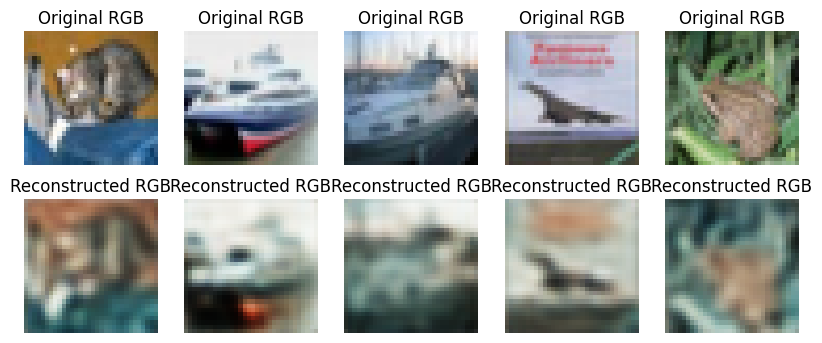

In [13]:
# Evaluate the expanded model on the full RGB data
mse_rgb = expanded_autoencoder.evaluate(x_test_rgb, x_test_rgb, batch_size=128)
print(f"Mean Squared Error (MSE) on full RGB data: {mse_rgb:.4f}")

import matplotlib.pyplot as plt

# Generate predictions for the RGB test set
decoded_imgs_rgb = expanded_autoencoder.predict(x_test_rgb)

# Display original and reconstructed images side by side
n = 5  # Number of images to display
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original RGB image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_rgb[i])
    plt.title("Original RGB")
    plt.axis("off")

    # Display reconstructed RGB image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_rgb[i])
    plt.title("Reconstructed RGB")
    plt.axis("off")

plt.show()

Unfreeze and train all dimensions

In [14]:
# Unfreeze all layers in the expanded model
for layer in expanded_autoencoder.layers:
    layer.trainable = True

# Recompile the model with a suitable optimizer and loss
expanded_autoencoder.compile(optimizer="adam", loss="mean_squared_error")

In [15]:
# Train the model on the full RGB dataset
expanded_autoencoder.fit(
    x_train_rgb,
    x_train_rgb,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_rgb, x_test_rgb),
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.0077 - val_loss: 0.0046
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.0039 - val_loss: 0.0038


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0038
Mean Squared Error (MSE) on fine-tuned RGB data: 0.0038
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


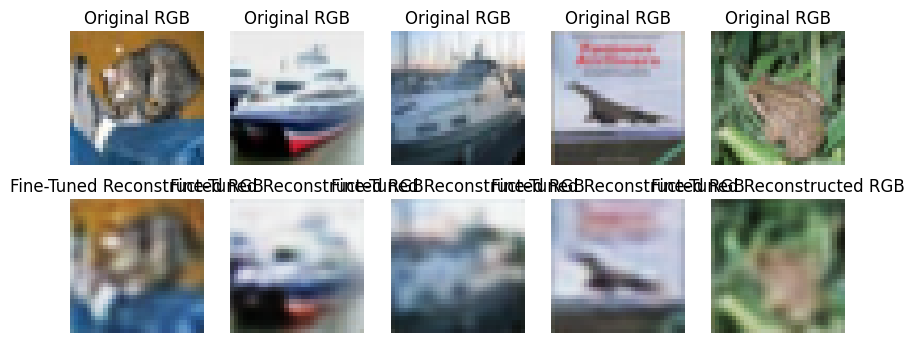

In [16]:
# Evaluate the fine-tuned model on the RGB data
mse_rgb_finetuned = expanded_autoencoder.evaluate(
    x_test_rgb, x_test_rgb, batch_size=128
)
print(f"Mean Squared Error (MSE) on fine-tuned RGB data: {mse_rgb_finetuned:.4f}")

# Generate predictions for the RGB test set with the fine-tuned model
decoded_imgs_rgb_finetuned = expanded_autoencoder.predict(x_test_rgb)

# Display original and fine-tuned reconstructed images side by side
n = 5  # Number of images to display
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original RGB image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_rgb[i])
    plt.title("Original RGB")
    plt.axis("off")

    # Display fine-tuned reconstructed RGB image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_rgb_finetuned[i])
    plt.title("Fine-Tuned Reconstructed RGB")
    plt.axis("off")

plt.show()